In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt


### import initial data

In [4]:
path = '../data/raw/task_data.csv'
df_original = pd.read_csv(path)
try:
    df_original.drop(['sample index'], axis = 1, inplace = True)
except:
    print('already deleted')
df_original.head()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [5]:
#checking normality
# from scipy.stats import normaltest

# for col in X.columns:
#     k2, px = normaltest(X[[col]])
#     sn.distplot(X[[col]])
#     plt.title(f'{col} distribution plot')
#     plt.show()

X_values = np.ravel(X.values)
sn.distplot(X_values)

NameError: name 'X' is not defined

### linear correlation
I am performing a simple check to see if there already exists a strong linear correlation between the data and the labels.

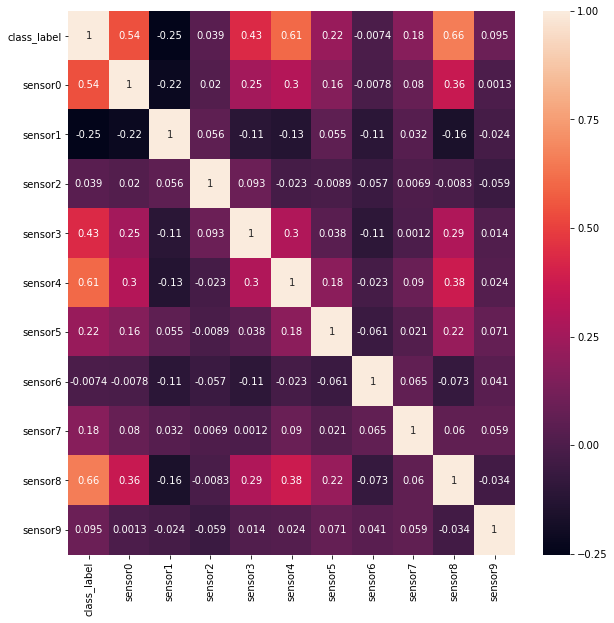

In [6]:
corrM= df_original.corr()
plt.figure(figsize = (10,10))
sn.heatmap(corrM, annot=True);

### Initial Observations:
- quickly looking over the initial observations, there appears to be a strong positive linear correlation between sensors 8, 4, 0 and 3 (in that order) and the class label. In addition to this, there is a negative correlation (.25) and the target data.
- there also appears to be an issue with colinearity amongst these sensors. Performing a Principle component analysis would help to reduce this and will be performed later.
- since there already exists a strong linear correlation with several of the sensors, a logistic regression would probably make for a good initial test

### checking distribution of the data:

In [7]:
# equall representation of target values
df_original.class_label.value_counts() 

-1.0    200
 1.0    200
Name: class_label, dtype: int64

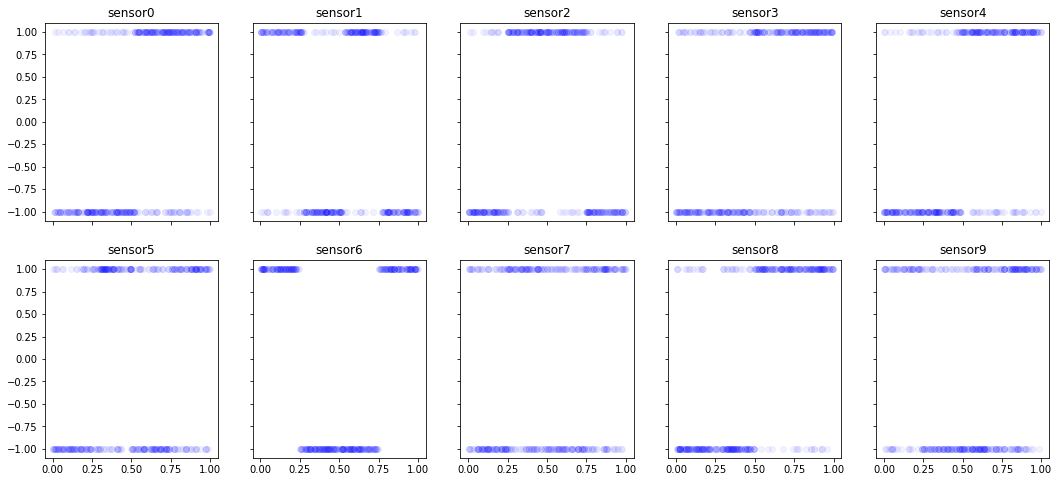

In [8]:
y = df_original.class_label
X = df_original.drop(['class_label'], axis = 1)


fig, axes = plt.subplots(nrows=2, ncols=5, sharey=True, sharex=True, figsize = (18,8))

for num, col in enumerate(X.columns):
    axes[num//5, num%5].plot(X[col], y, 'bo', alpha = .05)
    axes[num//5, num%5].set_title(f'{col}')
    axes[num//5, num%5]


### Further qualitative observations:
- after plotting the data, it appears that sensor 6 is also an extremely good candidate for predicting whether the information falls into class 1 or class 2.
- Sensor 6 didn't appear to show any correlation with the initial linear correlation test, this is because the correlation appears to be inheritantly non-linear. There may be some edge case issues for sensor 6 around .25 and .75 but else where, sensor 6 appears to be nearly perfect.
- additional sensors that appear to be good indicators and operate as a step functions are sensors: 0, 4, and 8. In addition to this, sensors: 1, 2, and possibly 5 & 9 appear to also be good predictors but aren't a single step function.
- After these initial observations, a simple logisitc regression will NOT at predicting the values while a Random Forest should do an excellent job capturing the data. 

### MODEL 1
for the first model, I will be using a Gradient Boosted Classifier as it should do an excellent job segmenting the input data

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split



# performing a train_test_split in order to cross-validate my results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

print(f'number of values in training set: {len(X_train)}')
print(f'number of values in testing set: {len(X_test)}')

number of values in training set: 320
number of values in testing set: 80


In [11]:
gbc = GradientBoostingClassifier(random_state = 42)

gbc.fit(X_train, y_train)

train_score = gbc.score(X_train, y_train)
test_score = gbc.score(X_test, y_test)

print(f'the f1_score for the training set was: {train_score}')
print(f'the f1_score for the testing set was: {test_score}')

the f1_score for the training set was: 1.0
the f1_score for the testing set was: 1.0


In [44]:
results = list(zip(X.columns, gbc.feature_importances_))
results.sort(key = lambda x: x[1], reverse = True)

for x in range(len(results)):
    print(f'{x+1}. {results[x][0]}')

1. sensor8
2. sensor6
3. sensor2
4. sensor4
5. sensor0
6. sensor1
7. sensor3
8. sensor5
9. sensor9
10. sensor7


### Post-model 1 Observations:
- The model appears to do an excellent job of predicting whether the ten factors correspond to  class 1 or class -1. The F1 Score for both training and the validation data was 1.0 indicating  a perfect model.
- While the model is excellent at predicting the correct class, I do not agree with the feature importance that the model produced. Looking at the plots, it is clear that sensor 6 is much better at predicting the results than sensor 8 as values, for sensor 6, in between .25 and .75 seem to always be classified as -1 while all values outside this range seem to be classified as 1. In comparison, sensor B visually splits along .5. There are, however, several misclassifications using sensor 8.
- The reason this occurs has to do with how a Gradient Boosting Classifier works. Each tree tries to minimize the amount of entropy after a single split. Since sensor 8 does a better job of reducing the entropy after a single split, the model assigns it a higher feature importance.
- While the model appears to do an excellent job of classifying the data (validation score of 1.0) The model under values sensors that require a multiple splits to represent the data (sensors 1,2,5, and 6 do an excellent job classifying the data but are undervalued because they require multiple)
- In a real world scenario, knowing which sensors are individually the best at classifying data could have significant practical implications. A hypothetical example of this may be:
    - If the sensors cost alot of money to operate, one would want to reduce the number of sensors used to capture the data.
- To give a more accurate representation of how each individual sensor performs in modeling the data, I will use a simple decision tree on each sensor to see how each performs as an individual classifier.

### Further Analysis/Individual Classifiers

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [46]:
# the min_samples_leaf is to protect against overfitting

scores = []
for col in X.columns:
    dtc = DecisionTreeClassifier(min_samples_leaf = 20, random_state = 42)
    dtc.fit(X_train[[col]], y_train)


    score = dtc.score(X_test[[col]], y_test)
    scores.append((col, score))
    

scores.sort(key = lambda x: x[1], reverse = True)

[[34  0]
 [ 1 45]]


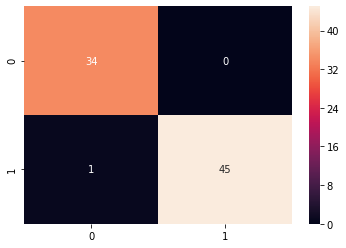

In [66]:
dtc = DecisionTreeClassifier(min_samples_leaf = 20, random_state = 42)
dtc.fit(X_train[['sensor1']], y_train)
preds = dtc.predict(X_test[['sensor1']])

conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

sn.heatmap(conf_matrix, annot = True, )

In [47]:
print("final f1 scores for individual decision trees:\n----------------------------------------------")
for num, score in enumerate(scores):
    print(f'{num + 1}. {score[0]} - validation score: {score[1]}')



final f1 scores for individual decision trees:
----------------------------------------------
1. sensor6 - validation score: 1.0
2. sensor1 - validation score: 0.9875
3. sensor2 - validation score: 0.9
4. sensor4 - validation score: 0.85
5. sensor8 - validation score: 0.85
6. sensor0 - validation score: 0.8
7. sensor5 - validation score: 0.775
8. sensor3 - validation score: 0.675
9. sensor9 - validation score: 0.675
10. sensor7 - validation score: 0.5625


### Conclusion

- Performing a decision tree classifier on the initial data reaffirms my initial suspision that sensor6 was indeed the best at classifying the original data. 
- While the Gradient boosted Classifier does accurately classify the data, the feature importance assigned to each sensor is incorrect as it undervalues sensors that require multiple splits to describe the data.
- In addition to this, much of the information is redundant and thus if time becomes an important restraint, a model based soley on sensor 6 will take mush less time to train and will perform much quicker


### Additional Model:
While this data is computer generated and thus unlikely to contain any mistakes due to random error, it is entirely possible that in a real life scenario, any one of the sensors may yield and incorrect value. Since there is huge redudancy within the information - many of the sensors by themselves are pretty good at predicting the class - we can use a voting classifier to protect against random error for any given sensor.

1. To illustrate this, I will first create a baseline with sensor 6 (the only decision tree that by itself had an f1 score of 1.0) and with the Boosted Gradient Classifier to show how a faulty sensor could reduce the f1 score of the data

In [52]:
# sensor 6 by itself.
np.random.seed(0)

dt1 = DecisionTreeClassifier(min_samples_leaf = 20, random_state = 42)
gb1 = GradientBoostingClassifier(random_state = 42)

dt1.fit(X_train[['sensor6']], y_train)
gb1.fit(X_train, y_train)

dt1_score = dt1.score(X_test[['sensor6']], y_test)
gb1_score = gb1.score(X_test, y_test)

X_faulty_test = X_test.copy()
X_faulty_test['sensor6'] = np.random.random(80)

faulty_dt1_score = dt1.score(X_test[['sensor6']], y_test)
faulty_gb1_score = gb1.score(X_test, y_test)



print('results - with fauly input values: \n---------------------------------------')
print(f'the f1_score for the the simple decision tree with faulty data: {faulty_score6}')
print(f'the f1_score for the the simple decision tree with good data: {score6}')
print(f'the f1_score for the gradient boosted classifier with faulty data: {faulty_gbc_score}')
print(f'the f1_score for the gradient boosted classifier with good data: {gbc_score}')




results - with fauly input values: 
---------------------------------------
the f1_score for the the simple decision tree with faulty data: 0.5
the f1_score for the the simple decision tree with good data: 1.0
the f1_score for the gradient boosted classifier with faulty data: 0.4625
the f1_score for the gradient boosted classifier with good data: 1.0


- for both the decision tree based on sensor 6 and the gradient boosted classifier, the f1_score sharply fell when their respective most important factors were changed to random numbers.
- one solution to protecting against possible random errors is to use a voting classifier which should protect against possible errors.

### Voting Classifier


In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score




def voting_classifier(X_test_, threshold = .7):
    """this function will take in a list of given input values and return an output"""
    estimators = []
    for num, col in enumerate(X.columns):
        exec(f'dt{num} = DecisionTreeClassifier(min_samples_leaf = 20).fit(X_train[[col]], y_train)')
        exec(f'w{num} = dt{num}.score(X_train[[col]], y_train)')
        exec(f'pred{num} = dt{num}.predict(X_test_[[col]])')
        exec(f'estimators.append((w{num}, pred{num}))')
        
    estimators_filtered = list(filter(lambda x: x[0] > threshold, estimators))

    classified_array = np.zeros(len(X_test_))
    for matrix in estimators_filtered:
        classified_array += matrix[1]
        
    classified_list = list(map(lambda x: 1 if x > 0 else -1, list(classified_array)))
    return classified_list
            
        

In [54]:
preds = voting_classifier(X_test, threshold = .7)
score = f1_score(y_test, preds)

preds_faulty = voting_classifier(X_faulty_test, threshold = .7)
score_faulty = f1_score(y_test, preds_faulty)

score_faulty

0.9782608695652174